In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import time

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


In [3]:
# Data Loading & Splitting

# Load data
images = np.load("Data/sample_1000_image.npy")
labels = np.load("Data/sample_1000_label.npy")

# Normalize image data.  0-255 to 0-1
images = images / 255
df = pd.DataFrame(np.concatenate((images, labels), axis=1))

# Rename the last column as "label"
df.rename(columns={784:"label"}, inplace=True)

# Convert label column to integer type
df['label'] = df['label'].astype('int64')

# Get "img" data frame and "lbl" series from the df
img = df.iloc[:, 0:-1]
lbl = df['label']

# Split into train and test set
x_train, x_test, y_train, y_test = train_test_split(img, lbl, test_size = 0.20, random_state = 123, stratify = lbl)

# Reset all the indices (from 0 to length-1)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [4]:
# Display the first 10 rows in the data frame
df.iloc[0:10]

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
# PCA for Dimensionality Reduction

from sklearn.decomposition import PCA

pca = PCA(n_components=784)
data_pca = pca.fit_transform(x_train)

256

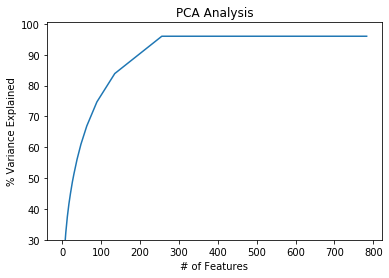

In [6]:
# Plot pca graph
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var)

# Display the smallest number of components that preserves the largest variance
np.argmax(var)

In [9]:
start_time = time.time()

# Reduce the number of dimensions to 100
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train)

# Transform testing set
x_test_pca = pca.transform(x_test)

print(x_train_pca.shape)
print(x_test_pca.shape)
print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

(276000, 100)
(69000, 100)
Time elapsed: 0.22 min


In [14]:
# Directly load data transformed by autoencoder

# Load data
x_train_ae = np.load("Data/xtrain_ae.npy")
x_test_ae = np.load("Data/xtest_ae.npy")
y_train_ae = np.load("Data/ytrain_ae.npy")
y_test_ae = np.load("Data/ytest_ae.npy")

In [17]:
print(x_train_ae.shape)
print(x_test_ae.shape)
print(y_train_ae.shape)
print(y_test_ae.shape)

(276000, 100)
(69000, 100)
(276000,)
(69000,)


In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# k-NN Classifier

start_time = time.time()

# Use PCA transformed data with 15 neighbors
knn = KNeighborsClassifier(n_neighbors=15, algorithm = 'auto', n_jobs = -1)
knn.fit(x_train_pca, y_train)
acc_train = knn.score(x_train_pca, y_train) * 100
acc_test = knn.score(x_test_pca, y_test) * 100
print('train set accuracy: %.2f%%' % acc_train)
print('test set accuracy: %.2f%%' % acc_test)

print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))b

train set accuracy: 41.90%
test set accuracy: 32.72%
Time elapsed: 76.72 min


In [29]:
# k-NN Classifier

start_time = time.time()

# Use Autoencoder transformed data with 15 neighbors
knn = KNeighborsClassifier(n_neighbors=15, algorithm = 'auto', n_jobs = -1)
knn.fit(x_train_ae, y_train_ae)
acc_train = knn.score(x_train_ae, y_train_ae) * 100
acc_test = knn.score(x_test_ae, y_test_ae) * 100
print('train set accuracy: %.2f%%' % acc_train)
print('test set accuracy: %.2f%%' % acc_test)

print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

train set accuracy: 37.01%
test set accuracy: 26.13%
Time elapsed: 88.17 min


In [ ]:
# Logistic Regression Classifier

In [ ]:
# Random Forest Classifier